In [203]:
import pandas as pd
import numpy as np
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline 
from math import sqrt
from sklearn.metrics import mean_squared_error

In [103]:
sales = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv')
cal = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/calendar.csv')

In [104]:
#take the dataframe and only present the relevant category
def filter_sales(frame, column, column_value):
    newframe = frame[frame[column] == column_value]
    return newframe

In [217]:
#drop unnecessary columns
def drop_col(frame, columns):
    newframe = frame.copy()
    newframe = newframe.drop(columns, axis='columns')
    return newframe 

In [106]:
#aggregate items from each store 
def aggregate(frame, category_id): 
    newframe = frame.groupby(category_id).sum()
    return newframe

In [107]:
#sum items for each day 
def total_sales(frame, column_name):
    newframe = pd.DataFrame()
    newframe[column_name] = frame.sum()
    newframe2 = newframe.reset_index()
    newframe3 = newframe2.rename(columns={'index':'d'})
    return newframe3

In [108]:
#merge sales with calendar 
def merge_pd(frame1, frame2, merge_index):
    newframe = pd.merge(frame1, frame2, on = merge_index, how = 'inner')
    newframe.date = pd.to_datetime(newframe.date)
    return newframe

In [109]:
#Encode column values to binary 
def events_encode(frame, column):
    newframe = frame.copy()
    newframe[column] = frame[column].fillna(0)
    for i in range(len(frame)):
        if type(frame[column][i])==str:
            newframe[column][i] = 1
    return newframe    

In [238]:
#Add week of year feature 
def week_of_year(frame):
    newframe = pd.DataFrame()
    newframe['week_of_year'] = np.arange(len(frame))
    newframe.week_of_year= frame.date.dt.isocalendar().week
    newframe2 = frame.copy()
    newframe2['week_of_year'] = newframe
    return newframe2

In [253]:
#ETSmodel prediction feature
def ETS_predict(frame, column_to_predict, days_to_predict):
    modelETS = ETSModel(frame.set_index('date')[column_to_predict].iloc[:-days_to_predict]/100, error="add", trend="add", seasonal="add",
                damped_trend=False, seasonal_periods=7)
    fit = modelETS.fit()
    x = fit.predict(start= frame.date.min(), end= frame.date.max())
    frame = frame.assign(ETS=x.values*100).set_index('date')
    return frame

In [207]:
#Create training/test dataset
def train_test_set(frame, item, start, end):
    newframe = frame[start:end]
    input_train = newframe.drop(item, axis='columns')
    target_train = newframe[item]
    return input_train, target_train 

In [205]:
#Model and predict data using Random Forest 
def forest(X_train, y_train, X_test):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return y_predicted 

In [114]:
df1 = filter_sales(sales, 'dept_id' , 'FOODS_3')
df1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2226,FOODS_3_001_CA_1_evaluation,FOODS_3_001,FOODS_3,FOODS,CA_1,CA,1,1,1,1,...,0,0,0,1,0,0,1,0,0,2
2227,FOODS_3_002_CA_1_evaluation,FOODS_3_002,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,5,1,5,2,1,0,1,0,1,1
2228,FOODS_3_003_CA_1_evaluation,FOODS_3_003,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,2,2,0,0
2229,FOODS_3_004_CA_1_evaluation,FOODS_3_004,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,1,0,0,1,1,0,2,2,1
2230,FOODS_3_005_CA_1_evaluation,FOODS_3_005,FOODS_3,FOODS,CA_1,CA,1,0,1,2,...,1,2,0,0,0,0,0,1,0,1


In [218]:
dfnew = drop_col(df1, ['id', 'dept_id', 'cat_id', 'store_id', 'state_id'])
dfnew.head()

,item_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2226,FOODS_3_001,1,1,1,1,1,0,1,2,1,...,0,0,0,1,0,0,1,0,0,2
2227,FOODS_3_002,0,0,0,0,0,0,0,0,0,...,5,1,5,2,1,0,1,0,1,1
2228,FOODS_3_003,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,2,2,0,0
2229,FOODS_3_004,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,2,2,1
2230,FOODS_3_005,1,0,1,2,2,0,1,1,3,...,1,2,0,0,0,0,0,1,0,1


In [116]:
df2 = aggregate(dfnew, 'item_id')
df2.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_001,7,8,7,13,5,8,10,19,14,9,...,4,7,11,4,5,8,11,9,12,13
FOODS_3_002,0,0,0,0,0,0,0,0,0,0,...,33,41,42,41,35,19,23,23,35,26
FOODS_3_003,0,0,0,0,0,0,0,0,0,0,...,11,7,13,10,3,5,7,7,3,6
FOODS_3_004,0,0,0,0,0,0,0,0,0,0,...,3,7,2,1,3,5,4,6,6,2
FOODS_3_005,4,9,3,10,7,12,6,9,12,6,...,7,11,11,11,6,8,13,16,6,16


In [117]:
df2.shape

(823, 1941)

In [118]:
df3 = total_sales(df2, 'FOODS_3')
df3.head()

,d,FOODS_3
0,d_1,16741
1,d_2,16333
2,d_3,12343
3,d_4,13764
4,d_5,10525


In [119]:
df4 = merge_pd(cal, df3, 'd')
df4.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,FOODS_3
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,16741
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,16333
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,12343
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,13764
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,10525


In [120]:
df5 = drop_col(df4, ['wm_yr_wk', 'weekday', 'year', 'd', 'event_name_1',
                     'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'])
df5.head()

,date,wday,month,event_type_1,FOODS_3
0,2011-01-29,1,1,NaN,16741
1,2011-01-30,2,1,NaN,16333
2,2011-01-31,3,1,NaN,12343
3,2011-02-01,4,2,NaN,13764
4,2011-02-02,5,2,NaN,10525


In [121]:
df5.groupby('event_type_1')['event_type_1'].agg('count')

event_type_1
Cultural     37
National     51
Religious    54
Sporting     16
Name: event_type_1, dtype: int64

In [122]:
df5

,date,wday,month,event_type_1,FOODS_3
0,2011-01-29,1,1,NaN,16741
1,2011-01-30,2,1,NaN,16333
2,2011-01-31,3,1,NaN,12343
3,2011-02-01,4,2,NaN,13764
4,2011-02-02,5,2,NaN,10525
...,...,...,...,...,...
1936,2016-05-18,5,5,NaN,17069
1937,2016-05-19,6,5,NaN,16935
1938,2016-05-20,7,5,NaN,19586
1939,2016-05-21,1,5,NaN,23464


In [123]:
df6 = events_encode(df5, 'event_type_1')
df6.head()

<ipython-input-109-dafa18f6c3d5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newframe[column][i] = 1


,date,wday,month,event_type_1,FOODS_3
0,2011-01-29,1,1,0,16741
1,2011-01-30,2,1,0,16333
2,2011-01-31,3,1,0,12343
3,2011-02-01,4,2,0,13764
4,2011-02-02,5,2,0,10525


In [237]:
df6.date.dt.isocalendar().week

0        4
1        4
2        5
3        5
4        5
        ..
1936    20
1937    20
1938    20
1939    20
1940    20
Name: week, Length: 1941, dtype: UInt32

In [239]:
df7 = week_of_year(df6)
df7.head()

,date,wday,month,event_type_1,FOODS_3,week_of_year
0,2011-01-29,1,1,0,16741,4
1,2011-01-30,2,1,0,16333,4
2,2011-01-31,3,1,0,12343,5
3,2011-02-01,4,2,0,13764,5
4,2011-02-02,5,2,0,10525,5


In [254]:
df8 = ETS_predict(df7, column_to_predict='FOODS_3', days_to_predict=120)
df8

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,wday,month,event_type_1,FOODS_3,week_of_year,ETS
date,,,,,,
2011-01-29,1,1,0,16741,4,14360.207831
2011-01-30,2,1,0,16333,4,15197.741548
2011-01-31,3,1,0,12343,5,12000.992396
2011-02-01,4,2,0,13764,5,11521.478058
2011-02-02,5,2,0,10525,5,11963.640047
...,...,...,...,...,...,...
2016-05-18,5,5,0,17069,20,15367.524582
2016-05-19,6,5,0,16935,20,15521.681264
2016-05-20,7,5,0,19586,20,16354.892664


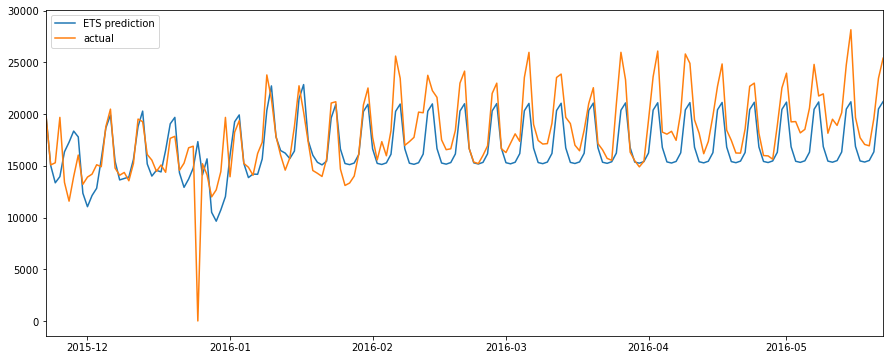

In [255]:
plt.figure(figsize=(15,6))
plt.plot(df8.ETS, label='ETS prediction')
plt.plot(df6.date, df6.FOODS_3, label='actual')
plt.xlim('2015-11-22', '2016-05-22')
plt.legend()

In [208]:
X_train,Y_train = train_test_set(df8,'FOODS_3', '2011-01-29', '2016-01-22')

In [209]:
print(X_train.shape, Y_train.shape)

(1820, 5) (1820,)


In [210]:
X_test,Y_test = train_test_set(df8,'FOODS_3', '2016-01-24', '2016-05-22')

In [211]:
print(X_test.shape, Y_test.shape)

(120, 5) (120,)


In [212]:
y_predicted = Forest(X_train, Y_train, X_test)
y_predicted

array([18746, 12368, 13216, 13120, 12983, 15807, 20452, 20832, 16699,
       17443, 14416, 15784, 17630, 23231, 20427, 16699, 17443, 17783,
       15784, 15432, 21030, 20427, 16976, 16960, 17783, 12155, 13180,
       21364, 20824, 17484, 14496, 14496, 13644, 15271, 19091, 20824,
       14949, 14684, 14296, 16058, 17492, 23136, 24470, 17986, 14684,
       14296, 16058, 16815, 20134, 21629, 16797, 14755, 14497, 15778,
       16548, 20421, 22768, 15240, 13566, 14684, 14634, 15216, 18567,
       19970, 16337, 14287, 13363, 14929, 19775, 22010, 21595, 16749,
       18114, 17171, 18357, 19775, 22010, 22843, 16261, 14842, 15234,
       15813, 15976, 19144, 21287, 15905, 14103, 13788, 14806, 15979,
       19144, 20464, 14418, 13613, 15354, 15758, 15648, 20141, 21075,
       17347, 16084, 16454, 17362, 18384, 22637, 21075, 17347, 15709,
       15041, 15086, 16893, 21658, 24023, 20912, 16007, 15057, 15043,
       16545, 18756, 23815])

In [213]:
print(len(Y_test), len(y_predicted))

120 120


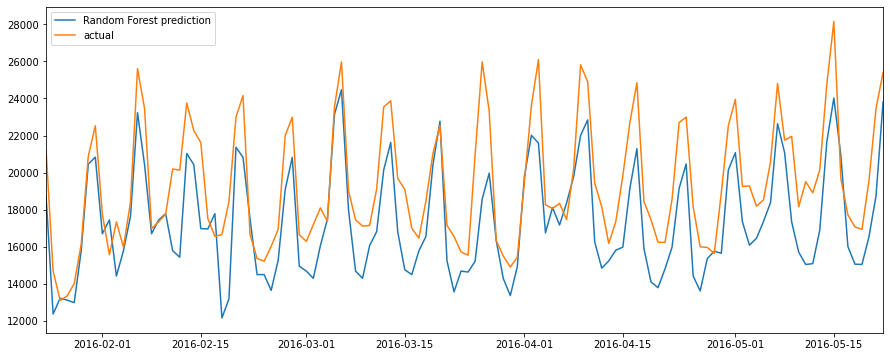

In [214]:
plt.figure(figsize=(15,6))
plt.plot(X_test.index, y_predicted, label='Random Forest prediction')
plt.plot(Y_test, label='actual')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()

In [190]:
len(df8['2016-01-24':'2016-05-22'])

120

In [204]:
#Compare FOODS_3 average sales with RMSE 
print("Average sales for foods(3) items is: ", Y_test.mean())
rmse = sqrt(mean_squared_error(Y_test, y_predicted))
print("Root mean squared error is: ", rmse)

Average sales for foods(3) items is:  19364.208333333332
Root mean squared error is:  2659.7769831322325


In [198]:
Y_test

date
2016-01-24    21197
2016-01-25    14694
2016-01-26    13106
2016-01-27    13341
2016-01-28    14012
              ...  
2016-05-18    17069
2016-05-19    16935
2016-05-20    19586
2016-05-21    23464
2016-05-22    25401
Name: FOODS_3, Length: 120, dtype: int64